In [33]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [34]:
# 2. Load Dataset
df = pd.read_csv('/content/customer_segmentation_dataset.csv')
display(df.head())
df.info()
df.describe()
df.isnull().sum()
df.nunique()


,CustomerID,Age,Gender,Annual_Income,Spending_Score,Purchase_Frequency,Avg_Basket_Value,Cluster_Sim
0,CUST02765,24,Female,22095,75,5,30.92,Young_low_income_high_spenders
1,CUST04768,20,Male,23960,70,8,35.76,Young_low_income_high_spenders
2,CUST03815,31,Female,42882,73,12,42.14,Young_mid_income_moderate_spenders
3,CUST03500,40,Female,33866,20,3,35.55,Middle_aged_low_income_low_spenders
4,CUST02736,33,Female,30240,10,0,24.28,Middle_aged_low_income_low_spenders


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          5000 non-null   object 
 1   Age                 5000 non-null   int64  
 2   Gender              5000 non-null   object 
 3   Annual_Income       5000 non-null   int64  
 4   Spending_Score      5000 non-null   int64  
 5   Purchase_Frequency  5000 non-null   int64  
 6   Avg_Basket_Value    5000 non-null   float64
 7   Cluster_Sim         5000 non-null   object 
dtypes: float64(1), int64(4), object(3)
memory usage: 312.6+ KB


,0
CustomerID,5000
Age,58
Gender,3
Annual_Income,4842
Spending_Score,99
Purchase_Frequency,25
Avg_Basket_Value,4156
Cluster_Sim,6


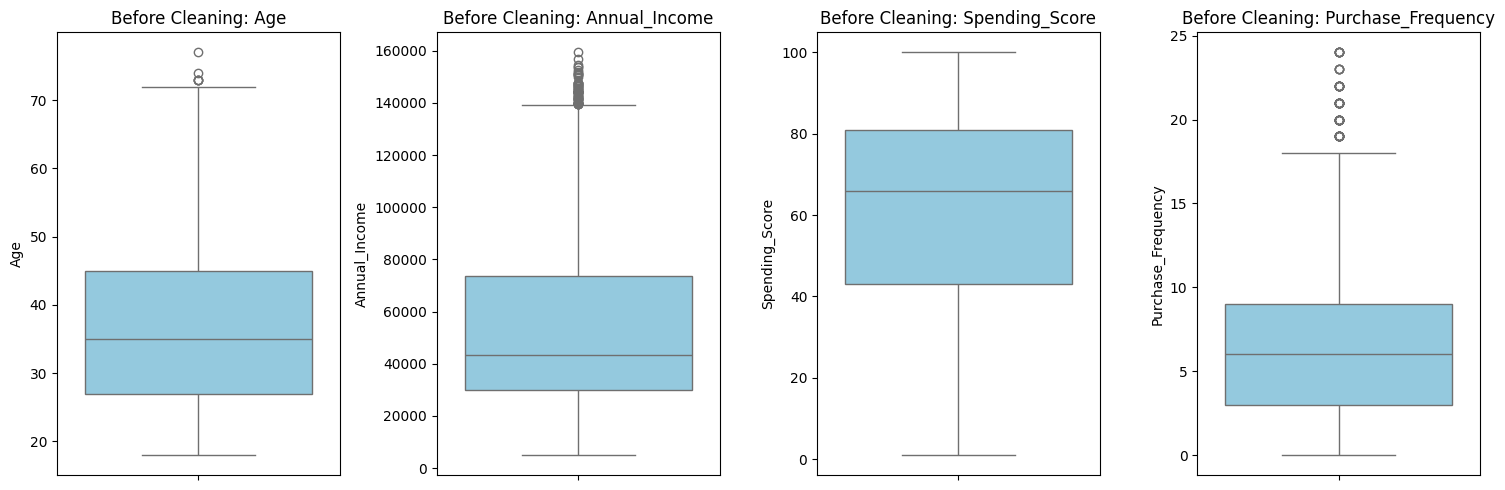

Removed 6 rows from Age
Removed 70 rows from Annual_Income
Removed 70 rows from Spending_Score
Removed 105 rows from Purchase_Frequency


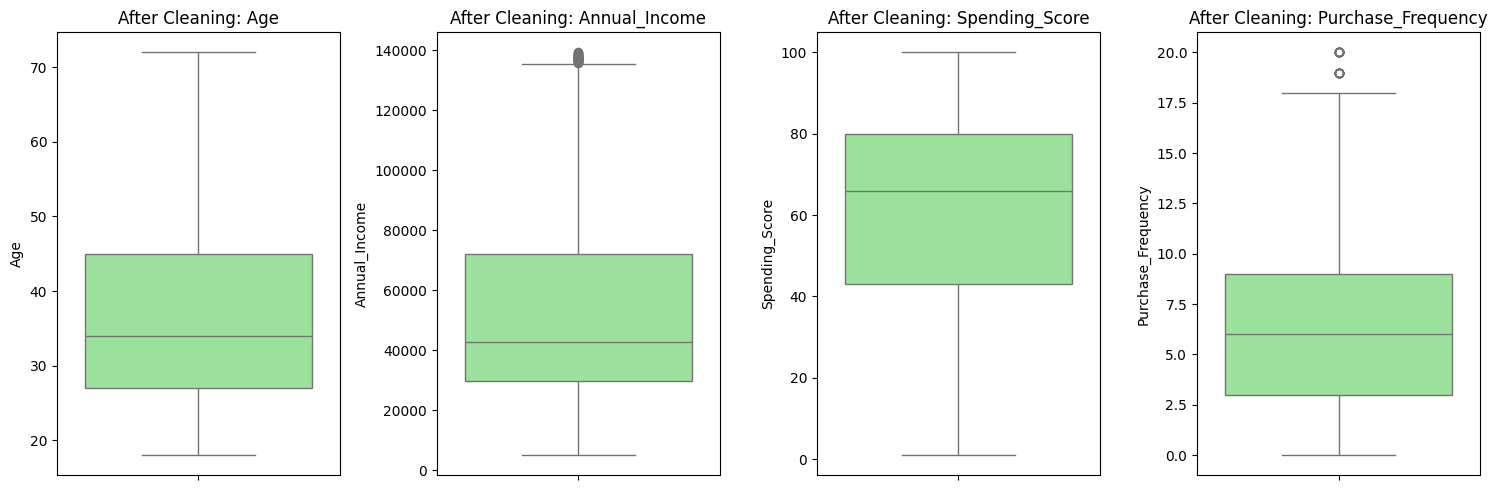

In [35]:
# 3. Data Cleaning
# Impute missing values
imputer = KNNImputer(n_neighbors=3)
df[['Age', 'Annual_Income', 'Spending_Score']] = imputer.fit_transform(df[['Age', 'Annual_Income', 'Spending_Score']])

# Define numerical columns
numerical_cols = ['Age', 'Annual_Income', 'Spending_Score', 'Purchase_Frequency']

# Boxplots before cleaning
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Before Cleaning: {col}')
plt.tight_layout()
plt.show()

# IQR-based outlier removal
df_cleaned = df.copy()
for col in numerical_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)]
    print(f"Removed {len(df) - len(df_cleaned)} rows from {col}")

# Boxplots after cleaning
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df_cleaned[col], color='lightgreen')
    plt.title(f'After Cleaning: {col}')
plt.tight_layout()
plt.show()


In [36]:
# 4. Feature Scaling
scaler = StandardScaler()
scaled = scaler.fit_transform(df_cleaned[numerical_cols])


In [37]:
# 5. PCA for Visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled)

pca_df = pd.DataFrame(pca_data, columns=['PCA_Component_1', 'PCA_Component_2'])


In [39]:
# 6. K-Means Clustering
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled)

df_cleaned['Cluster'] = clusters
pca_df['Cluster'] = clusters


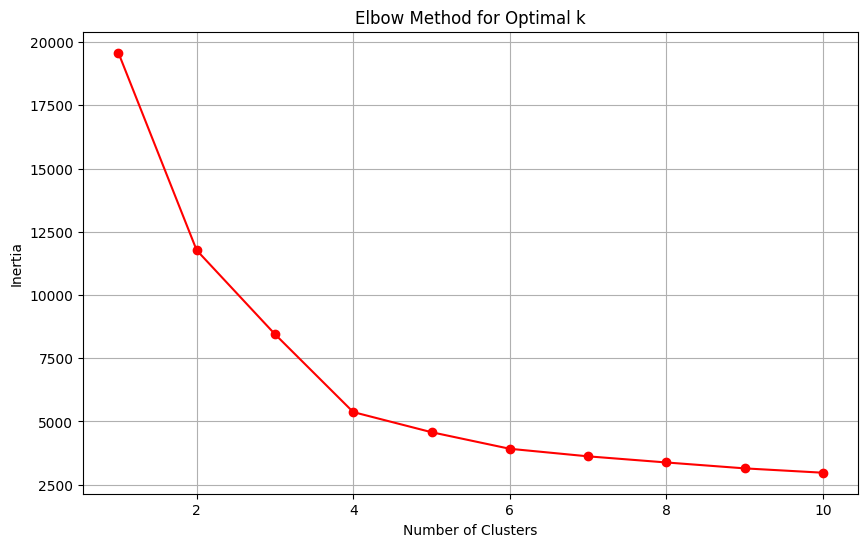

In [44]:
# 7. Elbow Method
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', color= 'red')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


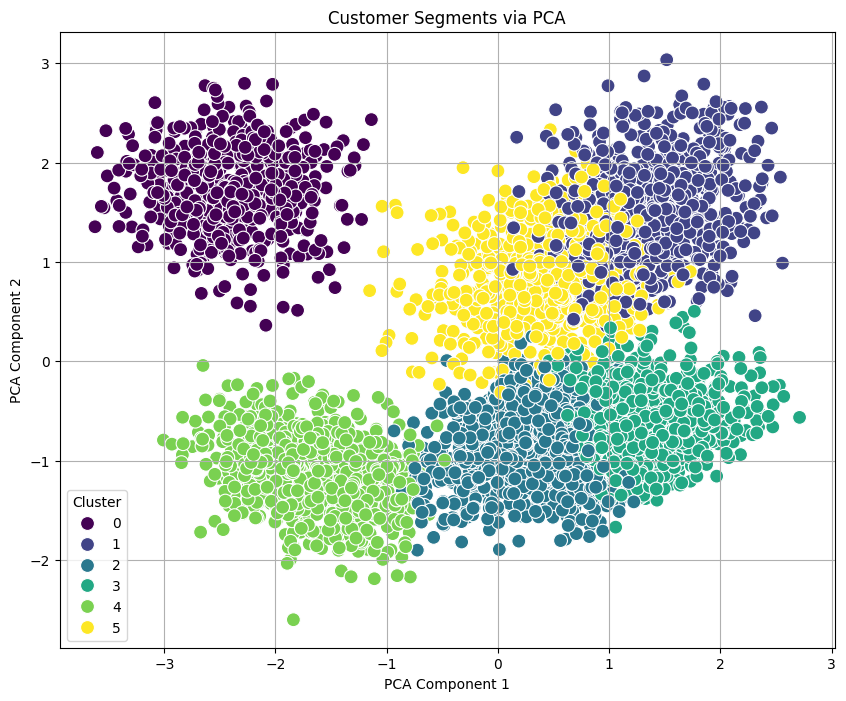

In [41]:
# 8. PCA Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA_Component_1', y='PCA_Component_2', hue='Cluster', data=pca_df, palette='viridis', s=100)
plt.title('Customer Segments via PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [42]:
# 9. Cluster Profiling
cluster_summary = df_cleaned.groupby('Cluster')[numerical_cols].mean()
print(cluster_summary)


               Age  Annual_Income  Spending_Score  Purchase_Frequency
Cluster                                                              
0        58.218579  117172.706740       40.240437            3.089253
1        37.923300   75848.384949       84.269175           13.884226
2        27.240656   38710.790337       59.090246            5.248861
3        25.258873   28954.075157       74.905010            9.031315
4        45.049605   29993.183766       29.276212            1.914318
5        38.769986   71199.798036       83.098177            7.115007


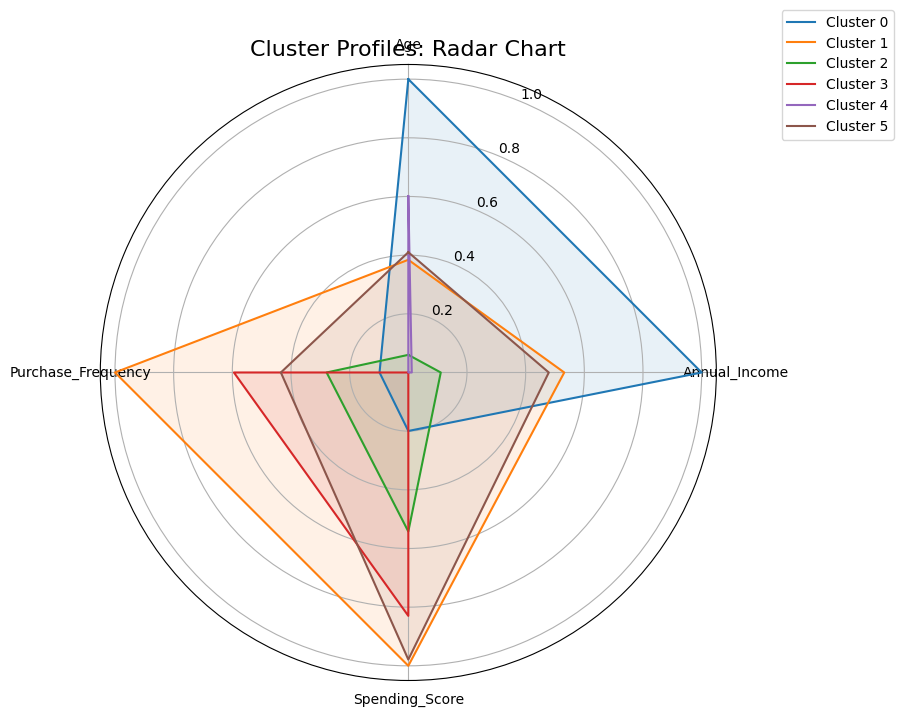

In [43]:
# 10. Radar Chart for Cluster Comparison
def plot_radar(data, labels, title):
    num_vars = len(data.columns)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for idx, row in data.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, label=f'Cluster {idx}')
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Normalize cluster summary
normalized_profiles = (cluster_summary - cluster_summary.min()) / (cluster_summary.max() - cluster_summary.min())
plot_radar(normalized_profiles, numerical_cols, 'Cluster Profiles: Radar Chart')


# Project Report Summary: Customer Segmentation Using Clustering

## 🎯 Objective
Segment customers into distinct groups based on purchasing behavior and demographics using unsupervised learning techniques.

## 📊 Methodology
- **Data Cleaning**: Handled missing values with KNN imputation and removed outliers using IQR method.
- **Feature Scaling**: Standardized numerical features to ensure clustering accuracy.
- **Dimensionality Reduction**: Applied PCA for 2D visualization of clusters.
- **Clustering Models**: Used K-Means (k=6) and evaluated with Elbow Method and Silhouette Score.
- **Cluster Profiling**: Analyzed cluster characteristics using mean values and radar charts.

## 📈 Key Findings
- Identified 6 distinct customer segments with varying age, income, spending behavior, and purchase frequency.
- PCA and pairplots revealed clear separation between clusters.
- Radar charts highlighted behavioral contrasts across segments.

## 💼 Business Insights
| Cluster | Profile Summary                                      | Strategic Action                         |
|---------|------------------------------------------------------|------------------------------------------|
| 0       | Young, low income, moderate spending                 | Upsell with budget-friendly bundles      |
| 1       | Middle-aged, high income, high spending              | Premium loyalty programs                 |
| 2       | High frequency, moderate income, low basket value    | Cross-sell and volume discounts          |
| 3       | Low frequency, high income, low spending             | Re-engage with exclusive offers          |
| 4       | Young, high spending, trend-driven                   | Influencer campaigns                     |
| 5       | Older, stable income, consistent spending            | Retention incentives                     |

## ✅ Conclusion
This segmentation enables personalized marketing strategies, improves customer targeting, and enhances overall business decision-making. The modular workflow and annotated visuals make this project portfolio-ready and adaptable for real-world applications.